Tutorial: utilize Azure Machine Learning Studio to train and deploy model for image detection task with pytorch tiny yolo v3 neutral network.

Check the AML core SDK version and config diagnostics functioon

In [3]:
import azureml.core
print("SDK version:", azureml.core.VERSION)
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

SDK version: 1.20.0
Turning diagnostics collection on. 


Get the AML warkspace parameters and print it out

In [4]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: cv_aml
Azure region: westus2
Subscription id: 2cb3bb6f-07cb-4778-8927-248b924cfaa7
Resource group: learnaml


Prepare training data as dataset

In [3]:
from azureml.core import Datastore
from azureml.core import Dataset
datastore = Datastore.register_azure_blob_container(workspace = ws, 
                                        datastore_name = 'img_ds',
                                        container_name = 'source-data',
                                        account_name = 'amlpocwestus6466069240',
                                        sas_token = '?sv=2019-12-12&ss=b&srt=co&sp=rlx&se=2021-03-31T15:28:38Z&st=2021-02-02T07:28:38Z&spr=https&sig=3KyJdypHKf%2FxktopuYLAbzy6YszG3LTpMUKHD5Qkn3I%3D',
                                        overwrite=False
                                        )
datastore_paths = [(datastore, 'anji_data')]
dataset = Dataset.File.from_files(path=datastore_paths)
print(datastore)

{
  "name": "img_ds",
  "container_name": "source-data",
  "account_name": "amlpocwestus6466069240",
  "protocol": "https",
  "endpoint": "core.windows.net"
}


Build Experiment named as exp-yolov3-sample for this training, deployment and inference process.
Prepare dependencies for yolo v3 pytorch implementation

In [4]:
from azureml.core import Experiment
from azureml.core import Environment
experiment_name = 'exp-yolov3-sample'
experiment = Experiment(ws, name=experiment_name)
pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', 
                                                file_path = './conda_dependencies.yml'
                                                )

Prepare Script parameters for this experiment. The parameters for training can be assigned here as arguments, 
such as -- epoches, --batchsizes,  --cfg and so on. The detailed parameters can be found in train.py file.
dataset must be mounted here. The path and name of dataset can be assigned differently.  

In [5]:
from azureml.core import ScriptRunConfig

project_folder = '.'
src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      arguments=['--epochs', 6,'--data-folder', dataset.as_mount('/tmp/tmp_imgdata')],
                      environment=pytorch_env)

Submit training request and run the training process. The labels and images of training data will be imported. 
The loss and other evaluation criteria will be calculated since the training processes after each epoch. 
The best model will be saved in outputs folder. Print intermediate results. 

In [6]:
run = experiment.submit(src,tags={"purpose":"AML yolov3 sample"})
print(run)

Run(Experiment: exp-yolov3-sample,
Id: exp-yolov3-sample_1612285597_801e8abb,
Type: azureml.scriptrun,
Status: Starting)


In [7]:
run.wait_for_completion(show_output=True)

RunId: exp-yolov3-sample_1612285597_801e8abb
Web View: https://ml.azure.com/experiments/exp-yolov3-sample/runs/exp-yolov3-sample_1612285597_801e8abb?wsid=/subscriptions/2cb3bb6f-07cb-4778-8927-248b924cfaa7/resourcegroups/learnaml/workspaces/cv_aml

Streaming azureml-logs/60_control_log.txt

[2021-02-02T17:06:45.743913] Entering context manager injector.
[2021-02-02T17:06:46.496547] Using urllib.request Python 3.0 or later
Streaming log file azureml-logs/60_control_log.txt
Running: ['/bin/bash', '/tmp/azureml_runs/exp-yolov3-sample_1612285597_801e8abb/azureml-environment-setup/conda_env_checker.sh']

Streaming azureml-logs/70_driver_log.txt

[2021-02-02T17:06:47.546761] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'Dataset:context_managers.Datasets', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError', 'UserExceptions:context_managers

Comfirm the training experiment is finished.

In [6]:
assert(run.get_status() == "Completed")
print(run.get_file_names())

NameError: name 'run' is not defined

Register the best Model

In [1]:
model = run.register_model(model_name = 'yolov3-sample-model', model_path = 'outputs/best.pt')
print(model.name, model.id, model.version, sep = '\t')

NameError: name 'run' is not defined

Deploy the Model with ACI Webservice method

In [7]:
from azureml.core import Environment
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', file_path = './conda_dependencies.yml')
dockerfile = """
FROM mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04
RUN apt update
RUN apt-get -y install sudo
RUN sudo apt -y install libgl1-mesa-glx
"""
pytorch_env.docker.enabled = True
pytorch_env.docker.base_image = None
pytorch_env.docker.base_dockerfile = dockerfile
pytorch_env.inferencing_stack_version = 'latest'

inference_config = InferenceConfig(
        entry_script="score.py", 
        environment=pytorch_env,
        source_directory = "./"
        )

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2, 
                                               memory_gb=2, 
                                               tags={'framework':'pytorch'},
                                               description='ACI with Yolov3')
model = Model(ws, 'yolov3-sample-model')

service = Model.deploy(workspace=ws, 
                           name='aci-yolov3-sample', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running............................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [8]:
service.get_logs()
print(service.scoring_uri)

http://feaab665-13ea-46a3-8b71-c772023104e7.westus2.azurecontainer.io/score


Use the deployed model to do inference process: input an image and use the deployed model to detect objects.

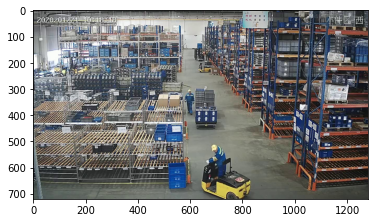

In [9]:
import json
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(Image.open('testfiles/test-image-2.jpg'))

In [10]:
import requests
from base64 import b64encode
# send a random row from the test set to score
with open('testfiles/test-image-2.jpg', 'rb') as jpg_file:
    byte_content = jpg_file.read()
    jpg_file.close()
base64_bytes = b64encode(byte_content)
base64_string = base64_bytes.decode()

input_data=json.dumps({'data': base64_string})

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

max_len = len(resp.text) -1
result = resp.text[1:max_len].replace("\\","")

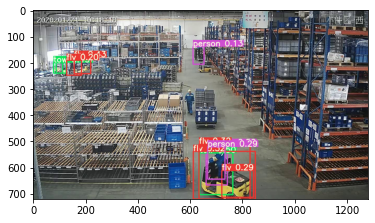

In [11]:
import base64

result_image = json.loads(result)["result_image"]

image_data = base64.b64decode(result_image)

with open('testfiles/test-impage-2-detection.jpg', 'wb') as jpg_file:
    jpg_file.write(image_data)

%matplotlib inline
plt.imshow(Image.open('testfiles/test-impage-2-detection.jpg'))

(Optional) Delete ACI and datastore

In [12]:
service.delete()
datastore.unregister()

NameError: name 'datastore' is not defined